# **Extra credit homework (25 points)**
(Due: before class on Wednesday 4/23/2025)

We’ve seen how powerful LSTM models can be for time-series forecasting. Here, let’s apply LSTM to stock prices. [Disclaimer: Please don’t use this model for real investing — you’ll lose money :) ]

In this Colab notebook, we’ll:

- Import Google stock price data
- Split it 80:20 into training:test
- Train an LSTM model on the training data
- Predict stock prices in the test region

When you run the notebook, you’ll see something surprising:

The predicted prices in the test set resemble the actual prices — including the ups and downs — quite well!

# **Your task:**

Why does the LSTM seem to forecast so accurately in the test region?  
What’s really going on under the hood?

Write a short explanation of what’s happening — especially during the prediction phase. Focus on what the model is seeing as input when making predictions.

# **My Answer**
In the prediction phase, past 60 days are used to predict the 1 next day. The data for past 60 days is accurate/actual stock prices, which is why the stock predictions are accurate. Should we increase the model's prediction to next 30 days, the error would compound as the model's own predictions will be fed back into the 60 previous days it uses to make a prediction. Hence, the model is decptively accurate.  

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Epoch [1/10], Loss: 0.0010
Epoch [2/10], Loss: 0.0003
Epoch [3/10], Loss: 0.0001
Epoch [4/10], Loss: 0.0001
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0002
Epoch [7/10], Loss: 0.0001
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0001


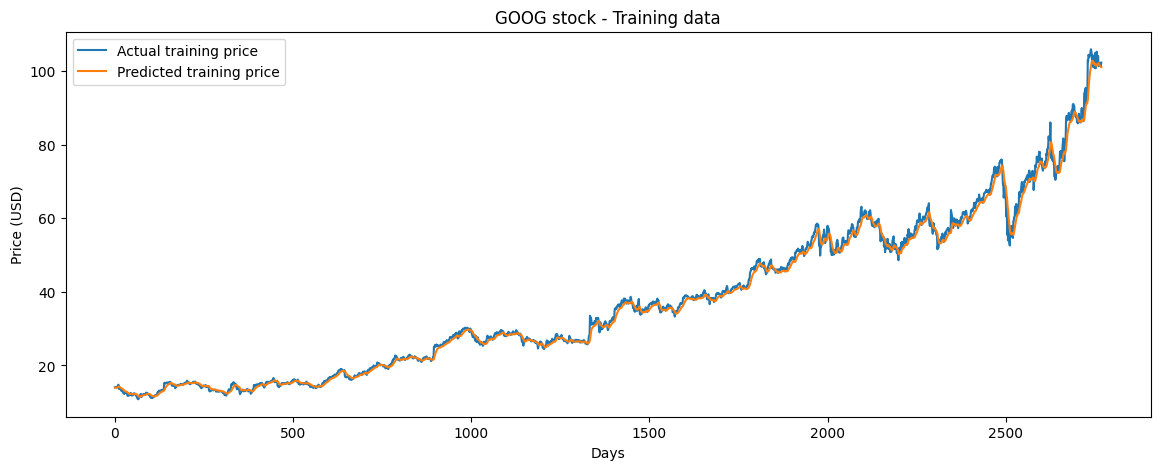

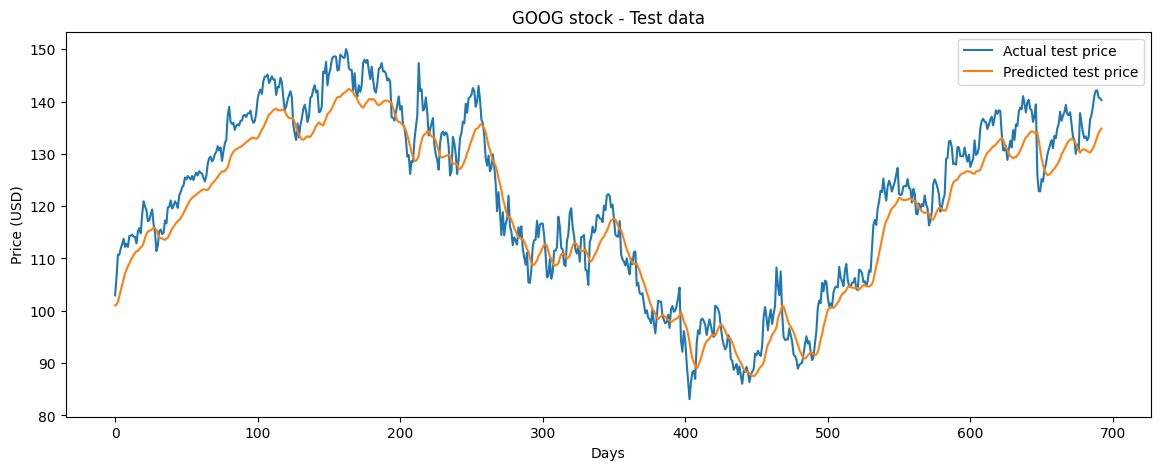

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. Download GOOG Stock Data
ticker = "GOOG"
start_date = "2010-01-01"
end_date = "2023-12-31"

# Fetch the data
df = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()
data = df.values.reshape(-1, 1)  # shape: (days, 1)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 3. Create sequences of 60-day windows
def create_sequences(series, seq_len=60):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 60
X_all, y_all = create_sequences(scaled_data, seq_len)

# 4. Train/Test Split (80/20)
split = int(0.8 * len(X_all))
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 5. Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    train_pred = model(X_train_tensor).numpy()
    test_pred = model(X_test_tensor).numpy()

# Inverse transform to get actual prices
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_actual = scaler.inverse_transform(y_train_tensor.numpy().reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))


# Plot training data and predictions
plt.figure(figsize=(14, 5))
plt.plot(y_train_actual, label='Actual training price')
plt.plot(train_pred, label='Predicted training price')
plt.title('GOOG stock - Training data')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Plot test data and predictions
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, label='Actual test price')
plt.plot(test_pred, label='Predicted test price')
plt.title('GOOG stock - Test data')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
